In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

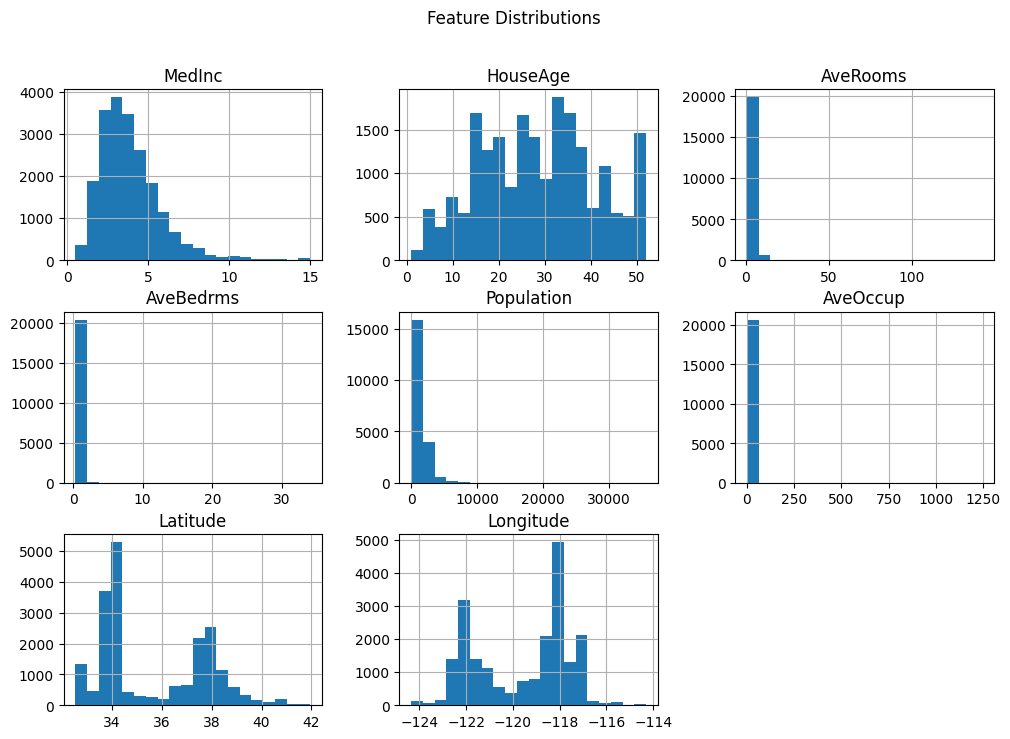

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

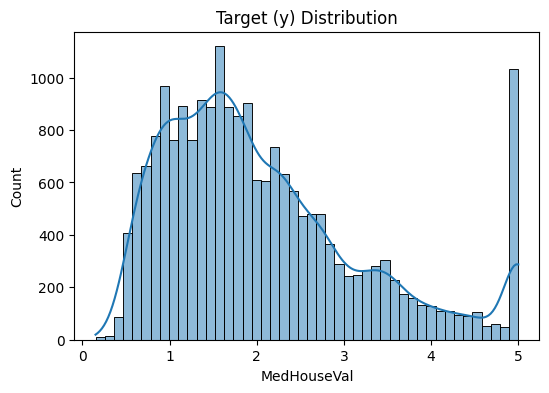

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

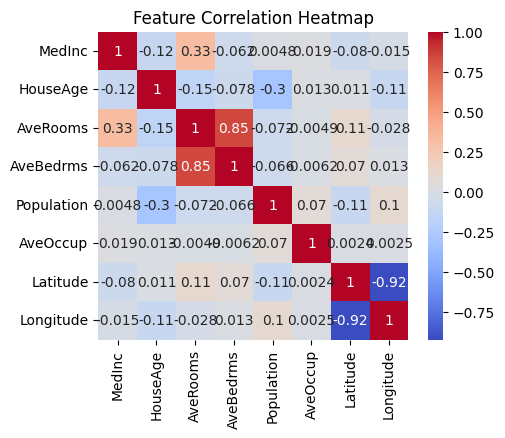

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=500, nskip=200, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.855878                 1.652056             1.765493   
1                  1.717343                 1.542657             1.467046   
2                  1.679327                 1.524938             1.340760   
3                  1.436956                 1.714037             1.870814   
4                  1.627245                 1.882803             1.686782   
mean               1.663350                 1.663298             1.626179   
std                0.152312                 0.145414             0.217781   

      DefaultBART_Rhat_RMSE  
0                  1.632927  
1                  1.741892  
2                  1.666140  
3                  1.758872  
4                  1.702547  
mean               1.700476  
std                0.052133  


In [10]:
rhat_df.to_csv("results/real3_CalHousing_rhat.csv", index=False)

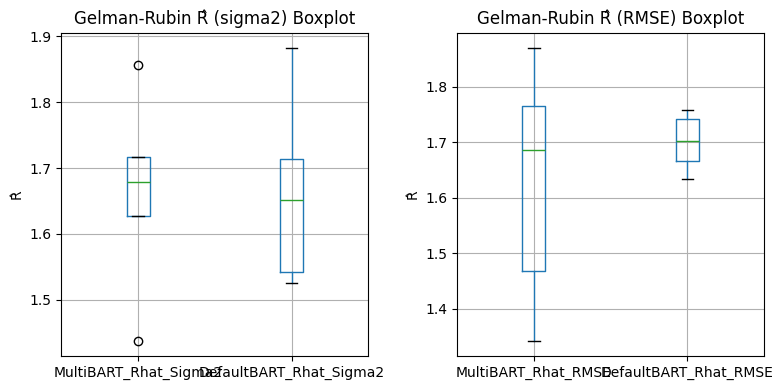

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      0.207343  0.219487  0.284305  0.275022  0.272077  0.218599
1      0.214852  0.227810  0.289723  0.264448  0.261053  0.217833
2      0.222803  0.235374  0.290290  0.277200  0.262780  0.226877
3      0.202928  0.212309  0.273101  0.261689  0.244403  0.213037
4      0.215048  0.225435  0.277822  0.276620  0.265763  0.223567
5      0.212312  0.228598  0.282850  0.283848  0.256011  0.223564
6      0.215287  0.223581  0.285769  0.273239  0.266254  0.228732
7      0.219214  0.226779  0.292375  0.267554  0.272183  0.226946
8      0.218247  0.226673  0.283058  0.271878  0.258861  0.219225
9      0.212930  0.217954  0.288779  0.264637  0.250178  0.214931
mean   0.214096  0.224400  0.284807  0.271614  0.260956  0.221331
std    0.005744  0.006448  0.005974  0.006954  0.008964  0.005385



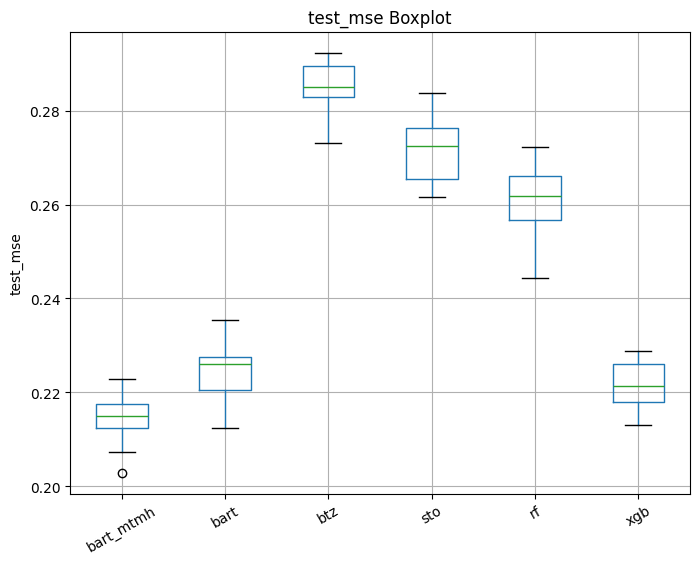

train_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      0.136022  0.173987  0.264529  0.256990  0.036417  0.070528
1      0.137087  0.173069  0.259645  0.237708  0.036316  0.071458
2      0.138449  0.170514  0.252435  0.240814  0.035701  0.067329
3      0.140055  0.176103  0.259378  0.263143  0.036103  0.072052
4      0.136428  0.175555  0.256427  0.247813  0.034991  0.072937
5      0.131993  0.166100  0.264643  0.252300  0.036166  0.067958
6      0.139214  0.172148  0.255568  0.245514  0.035877  0.070881
7      0.133463  0.169814  0.257327  0.237174  0.036120  0.072070
8      0.139312  0.166098  0.254505  0.246645  0.035792  0.069747
9      0.134910  0.171427  0.250741  0.243231  0.035288  0.072473
mean   0.136693  0.171481  0.257520  0.247133  0.035877  0.070743
std    0.002666  0.003478  0.004640  0.008344  0.000453  0.001893



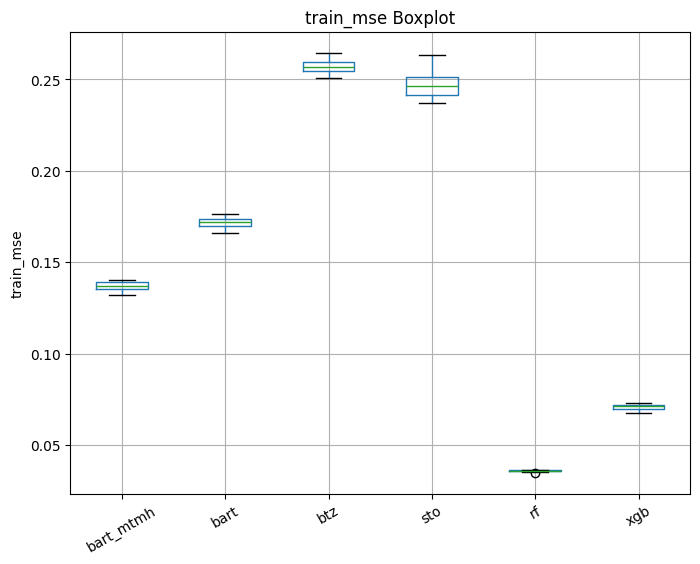

pi_length:
      bart_mtmh      bart       btz       sto
0      1.544070  1.699250  2.168196  1.204711
1      1.541316  1.691813  2.178575  1.163177
2      1.567369  1.692248  2.148396  1.175437
3      1.563795  1.701874  2.167664  1.198287
4      1.544807  1.709034  2.161997  1.221991
5      1.525246  1.664408  2.200802  1.251423
6      1.553153  1.687720  2.165216  1.224810
7      1.525863  1.672865  2.149907  1.129620
8      1.553864  1.673268  2.118945  1.166168
9      1.536142  1.687861  2.146975  1.246982
mean   1.545562  1.688034  2.160667  1.198260
std    0.014318  0.014130  0.021741  0.039445



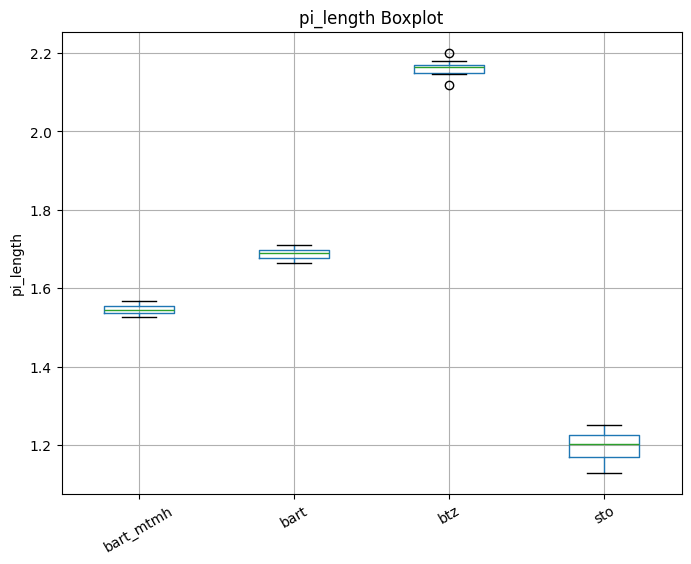

coverage:
      bart_mtmh      bart       btz       sto
0      0.928488  0.930426  0.950194  0.667054
1      0.919767  0.934496  0.949419  0.658721
2      0.923256  0.929651  0.946124  0.664729
3      0.927519  0.935659  0.950000  0.670543
4      0.927713  0.937016  0.952326  0.671318
5      0.917829  0.923256  0.948256  0.650969
6      0.925775  0.935465  0.948837  0.680039
7      0.918217  0.927907  0.943798  0.664922
8      0.920349  0.928876  0.943023  0.651550
9      0.921318  0.929845  0.944380  0.691667
mean   0.923023  0.931260  0.947636  0.667151
std    0.004088  0.004306  0.003127  0.012397



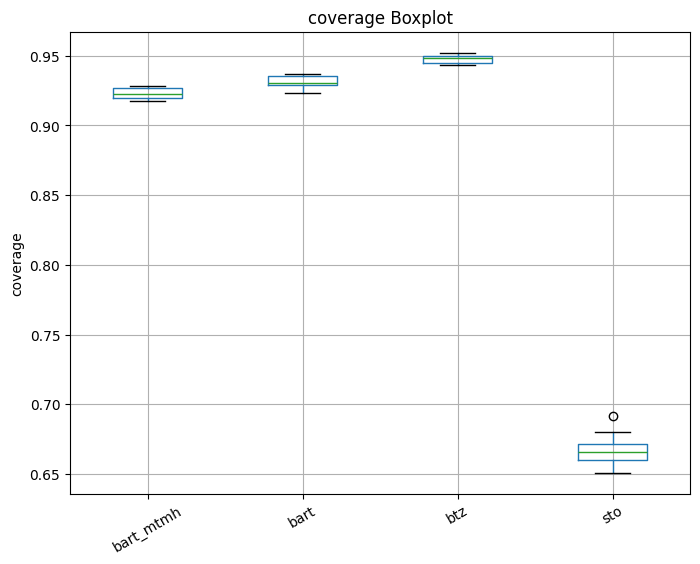

train_time:
       bart_mtmh       bart        btz         sto         rf       xgb
0     508.665015  75.840003  47.941160  169.569572  13.404739  0.282730
1     516.742335  74.387969  50.785688  166.575735  13.371191  0.290081
2     517.264236  70.615040  49.641973  168.177504  13.470513  0.284973
3     508.950810  70.430741  46.336447  171.857707  13.501685  0.329554
4     516.021330  73.421063  50.170039  168.473717  13.611735  0.244935
5     525.378157  71.955061  35.711526  186.110365  13.131213  0.114300
6     536.307323  81.414829  42.386354  171.723340  13.250846  0.117842
7     537.236623  81.184232  43.956434  165.757168  13.195473  0.105278
8     540.356501  88.944384  44.186326  164.270635  13.343061  0.120626
9     534.213340  83.771647  43.217663  164.901173  13.443943  0.113194
mean  524.113567  77.196497  45.433361  169.741692  13.372440  0.200351
std    12.127285   6.284790   4.574623    6.321786   0.147158  0.093025



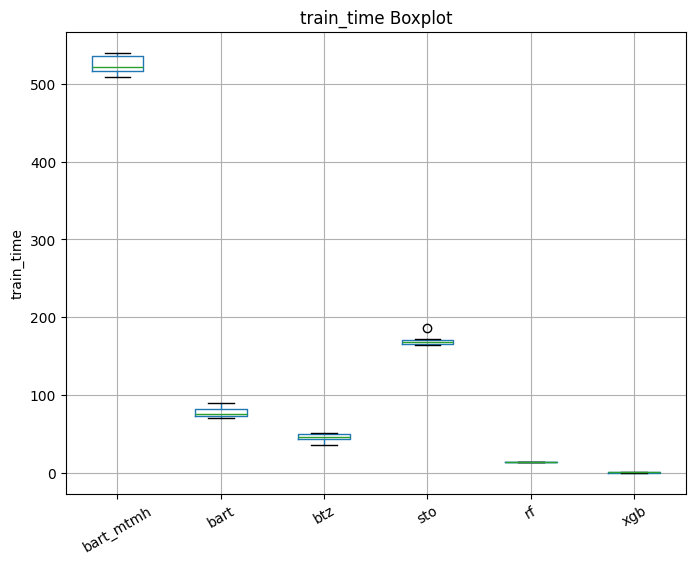

In [9]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [10]:
for k, v in mse_results.items():
    csv_name = f"results/real3_CalHousing_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real3_CalHousing_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real3_CalHousing_tries.csv", index=False)

In [12]:
df = pd.read_csv("results/real3_CalHousing_tries.csv")
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage   Train_Time
0            1     1.626068   1.812104  0.225922  0.934690   131.469112
1            5     1.655047   1.801385  0.216652  0.928217   375.526887
2           10     1.663350   1.626179  0.214031  0.927674   649.227517
3           50     1.608359   1.677233  0.212828  0.920233  3039.709455
4          100     1.587148   1.603739  0.215207  0.920659  6325.051871
